In [ ]:
#FCN SEGMENTATION
import matplotlib.image as img
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math
import os
from keras import layers
from keras.layers import Dropout,Input, Cropping2D,merge,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Lambda,Convolution2D,Conv2DTranspose,UpSampling2D,SeparableConv2D,DepthwiseConv2D
from keras.models import Model, load_model,Sequential
from keras.layers.merge import concatenate
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
import scipy.misc
import h5py
import keras.backend as K
import matplotlib.image as img
from keras.callbacks import ModelCheckpoint
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from keras.utils import multi_gpu_model
import keras

In [ ]:
###################################################################################################################
#####################################################残差模块######################################################
def residual_block(inp, filters):
    down_cut = inp
    inp = Activation('relu')(inp)
    inp = SeparableConv2D(filters, (3, 3),  padding='same')(inp)
    inp = Activation('relu')(inp)
    inp = SeparableConv2D(filters, (3, 3),  padding='same')(inp)
    inp = Add()([down_cut, inp])
    return inp
#####################################################分割网络#######################################################
def rpss_segnet(input_shape=(256, 256, 3),num_classes=1):
    inputs = Input(shape=input_shape)
    # 256x256x3
    down0 = Conv2D(8, (3, 3), padding='same')(inputs)
    down0 = residual_block(inp = down0, filters = 8)
    down0 = residual_block(inp = down0, filters = 8)
    down1 = Conv2D(32, kernel_size = (3, 3),strides = (2, 2), padding='same')(down0)
    down1 = residual_block(inp = down1, filters = 32)
    down1 = residual_block(inp = down1, filters = 32)
    down2 = Conv2D(64, (3, 3),strides = (2, 2), padding='same')(down1)
    down2 = residual_block(inp = down2, filters = 64)
    down2 = residual_block(inp = down2, filters = 64)
    down3 = Conv2D(128, (3, 3),strides = (2, 2), padding='same')(down2)
    for i in range(0, 4):
        down3 = residual_block(inp = down3, filters = 128)
    down4 = Conv2D(128, (3, 3),strides = (2, 2), padding='same')(down3)
    for i in range(0, 12):
        down4 = residual_block(inp = down4, filters = 128)
    up3 = Conv2DTranspose(filters=128,kernel_size=2, strides=(2,2),padding="same")(down4)
    up3 = Add()([down3, up3])
    for i in range(0, 6):
        up3 = residual_block(inp = up3, filters = 128)
    up2 = Conv2DTranspose(filters=64,kernel_size=2, strides=(2,2),padding="same")(up3)
    up2 = Add()([down2, up2])
    for i in range(0, 6):
        up2 = residual_block(inp = up2, filters = 64)
    up1 = Conv2DTranspose(filters=32,kernel_size=2, strides=(2,2),padding="same")(up2)
    up1 = Add()([down1, up1])
    for i in range(0, 6):
        up1 = residual_block(inp = up1, filters = 32)
    up0 = Conv2DTranspose(filters=8,kernel_size=2, strides=(2,2),padding="same")(up1)
    up0 = Add()([down0, up0])
    for i in range(0, 6):
        up0 = residual_block(inp = up0, filters = 8)
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)
    model = Model(inputs=inputs, outputs=classify)
    return model
############################################################################################################################

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0
def input_data():  
#     path_x = "data/train/person_x/" 
#     path_y = "data/train/person_y/"
    path_x = "data/train/Hair_X_256/" 
    path_y = "data/train/Hair_Y_256/"
    train_num =sum([len(x) for _, _, x in os.walk(os.path.dirname(path_x))])  
    image_train = np.zeros((train_num,256,256,3)) 
    label_train = np.zeros((train_num,256,256,1)) 
    count = 0
    for i in range(train_num):
        img = image.load_img(path_x + str(i) + ".bmp", target_size = (256, 256))
        x = image.img_to_array(img)
        gray = x.reshape((256,256,3))                
        image_train[count] = gray 
        img = image.load_img(path_y + str(i) + ".bmp", target_size = (256, 256))
        x = image.img_to_array(img)
        gray = rgb2gray(x)
        gray = gray.reshape((256,256,1))                                
        label_train[count] = gray
        count = count + 1
    return image_train, label_train

image_train, label_train = input_data()  
image_train = image_train.astype('float32')
label_train = label_train.astype('float32')
image_train /= 255.
label_train /= 255.
print("image_train:", str(image_train.shape))
print("label_train:", str(label_train.shape))
K.clear_session()

model = rpss_segnet(num_classes = 1)
# model.load_weights("model/hair_segmet.h5")#portrait_segnet.h5")
model.summary()
model.compile(optimizer = "adam", loss = 'binary_crossentropy',  metrics = ["accuracy"])
#checkpoint = ModelCheckpoint(filepath='model/portrait_segnet.h5',monitor='val_acc',mode='auto' ,save_best_only='True',save_weights_only='True')
checkpoint = ModelCheckpoint(filepath='model/hair_segmet.h5',monitor='val_acc',mode='auto' ,save_best_only='True',save_weights_only='True')
callback_lists=[checkpoint]
model.fit(image_train, label_train,epochs=50,verbose=1,validation_split=0.2, shuffle=True,batch_size=16,callbacks=callback_lists)
#model.save("model/portrait_segnet.h5")
model.save("model/hair_segmet.h5")
print("Model save done!")

In [4]:
#Test image
K.clear_session()
def fix_mask1(mask):
    mask[mask < 40] = 0.0
    mask[mask >= 40] = 255.0
np.random.seed(1)      
model1 = load_model('model/hair_segmet.h5')#portrait_segnet.h5')

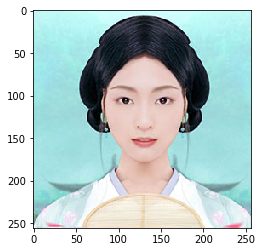

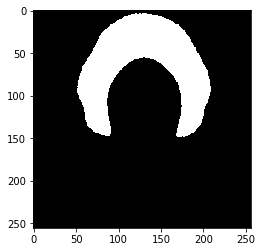

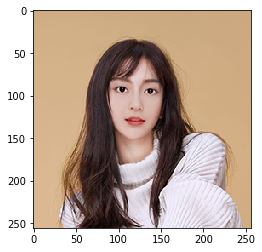

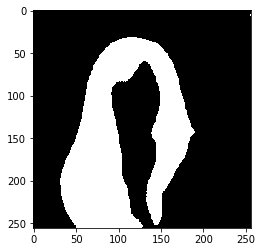

In [5]:
sess = K.get_session()

# for num in range(1500,1734):
for num in range(10000,10002):
    path_s = "data/test/person_x_test/"
    path = path_s + str(num) + ".bmp"
    path_save = "data/save/" + str(num) + "_s.jpg"
    image = img.imread(path)  
    plt.imshow(image)
    plt.show()
    image_test = image[:,:,:]  
    image = image_test.reshape(1,image_test.shape[0],image_test.shape[1],3)  
    image = image / 255.  
    res = model1.predict(image)
    amin, amax = res.min(),res.max()
    image = (res - amin) / (amax - amin) * 255.0
    image = image[0,...]
    image = image.reshape((256,256))
    fix_mask1(image)
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.show()
    img.imsave(path_save, np.uint8(image))

In [6]:
#####################################################H52Pb模型转换############################################################
from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K
#路径参数
input_path = 'input path'
weight_file = 'hair_segmet.h5'#portrait_segnet.h5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"trans_model")
#加载模型
h5_to_pb(model1,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

INFO:tensorflow:Froze 296 variables.
INFO:tensorflow:Converted 296 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/shuofeng/AIProject/UnetFaceSegment/trans_model
model saved
